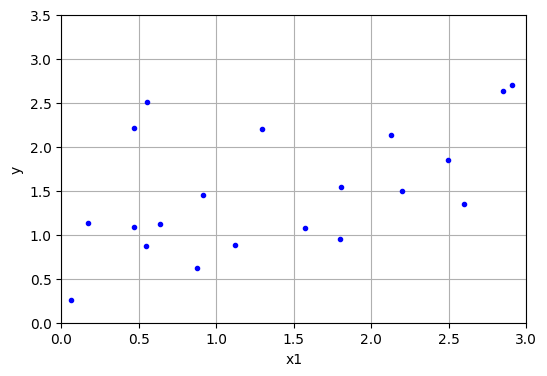

Ridge prediction at x=1.5: [1.55325833]


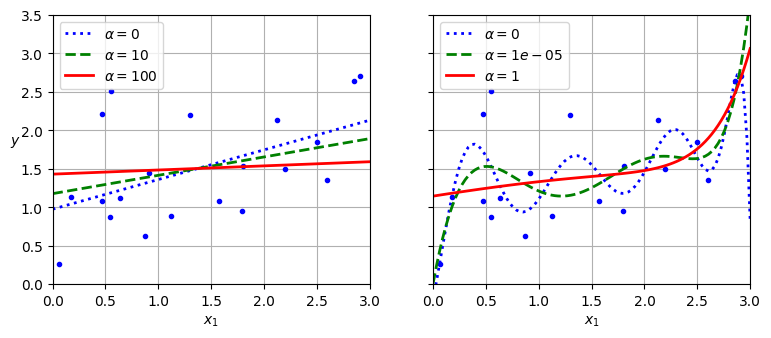

SGD prediction at x=1.5: [1.55302613]
Ridge (sag) prediction at x=1.5: [1.55326019]
Closed-form Ridge solution:
 [[0.97898394]
 [0.3828496 ]]
Model intercept and coefficients: [0.97896386] [0.38286422]
Lasso prediction at x=1.5: [1.53788174]


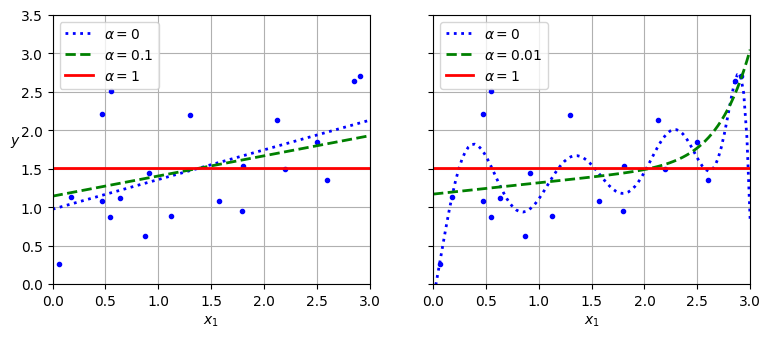

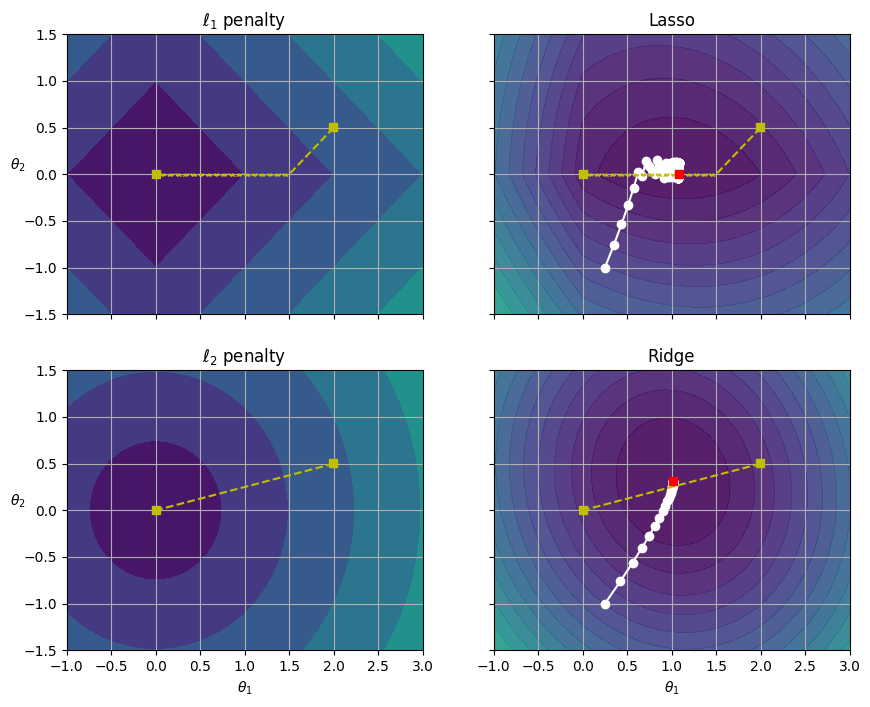

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# --------------------------
# Data Preparation
# --------------------------
np.random.seed(42)
m = 20
x = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * x + np.random.randn(m, 1) / 1.5
x_new = np.linspace(0, 3, 100).reshape(100, 1)

# --------------------------
# Helper Functions
# --------------------------
def plot_data(x, y):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, "b.")
    plt.xlabel("x1")
    plt.ylabel("y")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()
    plt.show()

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(x, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        model = model_class(alpha, **model_kwargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model
            )
        model.fit(x, y)
        y_pred = model.predict(x_new)
        plt.plot(x_new, y_pred, style, linewidth=2, label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

# --------------------------
# Initial Data Plot
# --------------------------
plot_data(x, y)

# --------------------------
# Ridge Regression
# --------------------------
ridge = Ridge(alpha=0.1, solver="cholesky")
ridge.fit(x, y)
print("Ridge prediction at x=1.5:", ridge.predict([[1.5]]))

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 1e-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

# --------------------------
# Stochastic Gradient Descent Ridge
# --------------------------
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(x, y.ravel())
print("SGD prediction at x=1.5:", sgd_reg.predict([[1.5]]))

# Ridge with SAG solver
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(x, y)
print("Ridge (sag) prediction at x=1.5:", ridge_reg.predict([[1.5]]))

# Closed form Ridge solution
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones((m, 1)), x]
theta_ridge = np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y
print("Closed-form Ridge solution:\n", theta_ridge)
print("Model intercept and coefficients:", ridge_reg.intercept_, ridge_reg.coef_)

# --------------------------
# Lasso Regression
# --------------------------
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x, y)
print("Lasso prediction at x=1.5:", lasso_reg.predict([[1.5]]))

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

# --------------------------
# Contour Plot: L1 (Lasso) vs L2 (Ridge)
# --------------------------
def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for _ in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

# Prepare data for contour plots
t1s = np.linspace(-1, 3, 500)
t2s = np.linspace(-1.5, 1.5, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]
J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)
N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

# Plot contours
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
titles = ["Lasso", "Ridge"]

for i, (N, l1, l2) in enumerate([(N1, 2.0, 0), (N2, 0, 2.0)]):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    t_min_idx = np.unravel_index(J.argmin(), J.shape)
    t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]
    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJR = levelsJ * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(np.array([[0.25], [-1]]), Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(np.array([[0.25], [-1]]), Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, l1=np.sign(l1)/3, l2=np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.contourf(t1, t2, N/2, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.grid()
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(titles[i])
    ax.grid()
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
plt.show()
